# Lecture 22: Non-convex constraints part 2: projected gradient descent

[EE227C course page](https://ee227c.github.io/)  
[Download ipynb file](https://ee227c.github.io/code/lecture20.ipynb)

Last lecture, we saw the $\ell_1$-relaxation approach to solving sparse linear systems.
Now we will experimentally explore how fast we can solve the corresponding optimization problems.
First, we treat the $\ell_1$-relaxation as a standard convex problem.
To speed things up, we then turn to a first order approach (projected gradient descent) and find that it works directly with projections onto the non-convex set.

In [1]:
%matplotlib notebook

import math
from timeit import default_timer as timer

import cvxpy # convex optimization library
import matplotlib.pyplot as plt
import numpy as np

from plotters import kwargs, setup_layout
setup_layout()

## A simple experiment with $\ell_1$-minimization

Let's set up a simple test problem of the form $y = A x$ with $s$-sparse $x$. As usual, the matrix $A$ has dimension $n \times d$. We sample the entries of $A$ as i.i.d. Gaussians so the matrix satisfies the restricted isometry property (RIP) if we take enough samples $n$.

In [2]:
d = 100
n = 50
s = 10

A = np.random.randn(n, d)
A /= math.sqrt(n) # Normalization so the matrix is RIP (optional)

support = np.random.choice(d, s, replace=False)
x_star = np.zeros(d)
x_star[support] = np.random.randn(s)

y = np.dot(A, x_star)

We write $\ell_1$-minimization as a convex optimization problem using [CVXPY](http://www.cvxpy.org/en/latest/). That way we don't have to worry about the algorithmic details for now (CVXPY uses an interior point method internally).

In [3]:
def l1min(y, A):
    x_hat = cvxpy.Variable(A.shape[1])
    objective = cvxpy.Minimize(cvxpy.norm(x_hat, 1))
    constraints = [A * x_hat == y]
    prob = cvxpy.Problem(objective, constraints)
    prob.solve()
    return np.squeeze(np.array(x_hat.value)), (prob.value, prob.status)

Let's see if we get an accurate solution, e.g., in terms of relative error.

In [4]:
x_hat, _ = l1min(y, A)

In [5]:
def relative_error(x_hat, x_star):
    return np.linalg.norm(x_hat - x_star) / np.linalg.norm(x_star)

In [6]:
relative_error(x_hat, x_star)

3.540258997388897e-11

Looks good!

## The phase transition of $\ell_1$ minimization

Next, let's check how many samples we need empirically for the $\ell_1$-relaxation to work.

For this, we repeat the recovery experiment above for an increasing number of samples from $n = 10$ to $n = 100$ (when the system becomes fully determined).

For each value of $n$, we run 20 trials and count how man of them succeed (relative recovery error less than $10^{-6}$).

In [7]:
d = 100
n_vals = np.linspace(10, 100, 20, dtype=np.int64)
s = 10

num_trials = 10
num_correct = np.zeros(len(n_vals))

for ii, n in enumerate(n_vals):
    for jj in range(num_trials):
        A = np.random.randn(n, d)
        A /= math.sqrt(n)

        support = np.random.choice(d, s, replace=False)
        x_star = np.zeros(d)
        x_star[support] = np.random.randn(s)

        y = np.dot(A, x_star)
        
        x_hat, _ = l1min(y, A)
        
        if relative_error(x_hat, x_star) < 1e-6:
            num_correct[ii] += 1
    
num_correct /= num_trials

Let's plot the empirical recovery probability as a function of $n$.

<IPython.core.display.Javascript object>


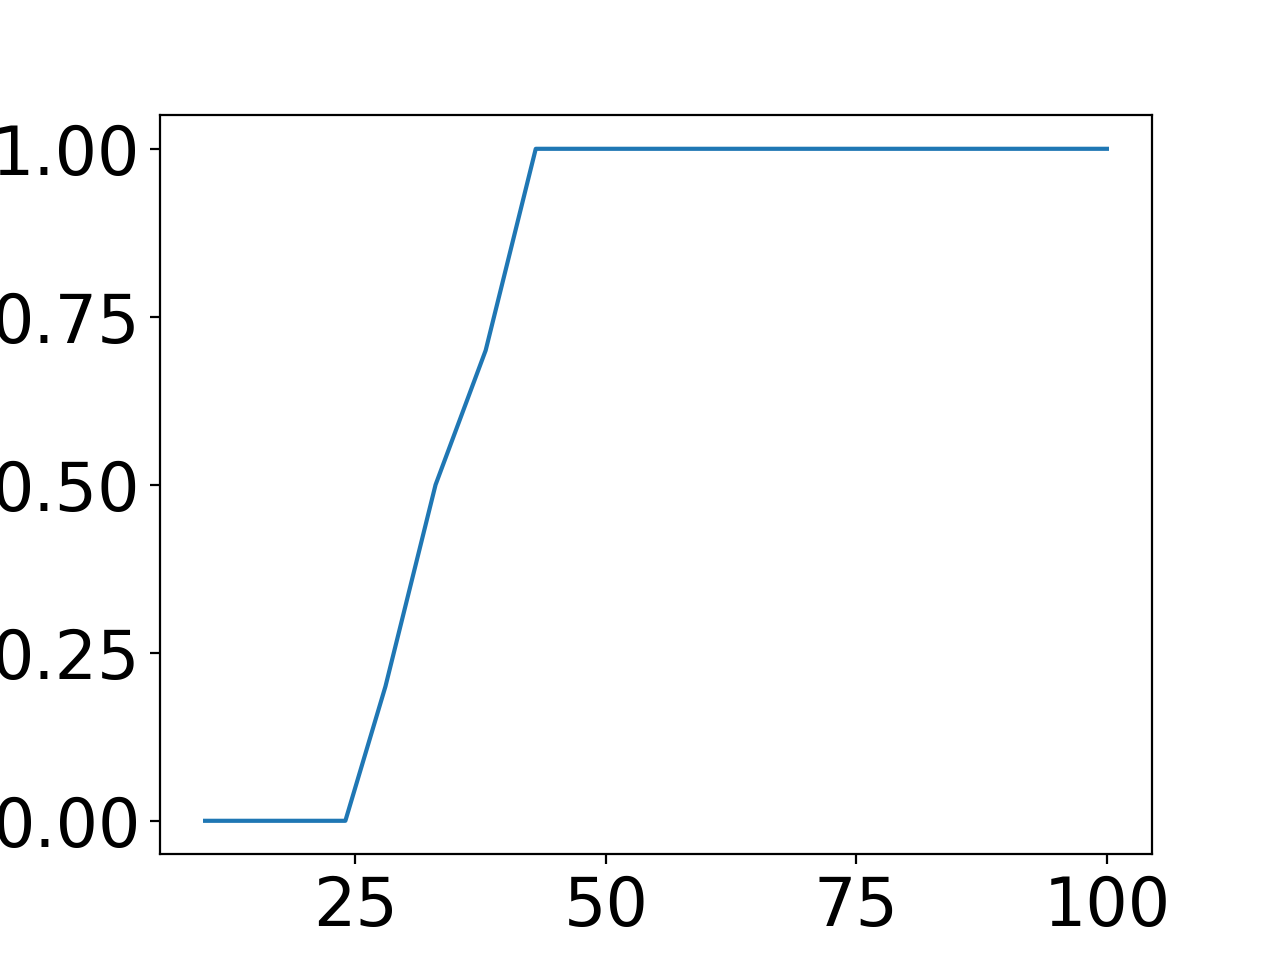

In [8]:
plt.figure()
plt.plot(n_vals, num_correct)
plt.xlabel('n')
plt.ylabel('Fraction correct')
plt.show()

Recall that an i.i.d. Gaussian matrix requires $O(s \log d / s)$ rows so it satisfies RIP (this corresponds to $n = O(s \log d / s)$ samples here). So the recovery phase transition occurs rougly where we'd expect (a small multiple of $s = 10$).

## Running time of $\ell_1$-minimization

Next, let's see how fast CVXPY solves our problem.

In [9]:
d = 4000
n = 2000
s = 10

A = np.random.randn(n, d)
A /= math.sqrt(n)

support = np.random.choice(d, s, replace=False)
x_star = np.zeros(d)
x_star[support] = np.random.randn(s)

y = np.dot(A, x_star)

start = timer()

x_hat, _ = l1min(y, A)

end = timer()

print('Relative error {}, took {} seconds'.format(relative_error(x_hat, x_star), end - start))

Relative error 1.4350742412631233e-11, took 132.5454451580299 seconds


This is starting to look somewhat slow:
* $d = 100$ and $n = 50$: 10 ms to get a solution
* $d = 1000$ and $n = 500$: 5 - 6 seconds
* $d = 4000$ and $n = 2000$: 112 seconds

As we will see later in the course, this is to be expected if we use interior point methods without exploiting further problem structure. While interior point methods reliably give us high-accuracy solutions, they can also be prohibitively slow for large-scale problems (in MRI reconstruction, we might easily have $d = 10^6$).

So if we want to solve very large instances, we should also consider first-order methods. In fact, it turns out that there is an interesting phenomenon here: instead of solving the convex relaxation via first order methods, let's see what happens if we directly run projected gradient descent with the non-convex set of sparse vectors.

## Projected gradient descent for sparse vectors

Projected gradient descent for sparse vectors is also known as Iterative Hard Thresholding (IHT) because the projection step (find the closest $s$-sparse vector) corresponds to hard thresholding the vector.
In particular, we keep only the $s$ largest entries (in absolute value) and set the rest to 0.

In [10]:
def hard_thresholding(x, s):
    result = np.zeros_like(x)
    large_indices = np.argpartition(np.abs(x), x.size - s)[x.size - s:]
    result[large_indices] = x[large_indices]
    return result

def IHT(y, A, s, step_size=1.0, max_iter=100):
    x_hat = hard_thresholding(np.dot(A.T, y), s)
    iterates = [x_hat]
    for num_iter in range(1, max_iter):
      step = np.dot(A.T, np.dot(A, x_hat) - y)
      x_hat = hard_thresholding(x_hat - step_size * step, s)
      iterates.append(x_hat)
    return x_hat, np.array(iterates)

Let's see how much faster the first-order approach is.

In [11]:
start = timer()

x_hat, iterates = IHT(y, A, s, max_iter=10)

end = timer()

print('Relative error {}, took {} seconds'.format(relative_error(x_hat, x_star), end - start))

Relative error 4.6825636345053085e-09, took 0.035713643999770284 seconds


More than $1000 \times$ faster - nice! But is IHT guaranteed to work? After all, the set of $s$-sparse vectors is not convex.

We'll prove this fact on the board next.